# Satellite Luminosity Function

In [19]:
import pynbody
import matplotlib.pyplot as plt
import numpy as np

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue,
                                          pynbody.halo.hop.HOPCatalogue]

s = pynbody.load('h148.cosmo50PLK.3072g3HbwK1BH/h148.cosmo50PLK.3072g3HbwK1BH.004096/h148.cosmo50PLK.3072g3HbwK1BH.004096')
h = s.halos()

In [12]:

halo = h.load_copy(2)
halo.physical_units()
halo.dm['mass'].sum()

SimArray(8.5370585e+10, 'Msol')

In [13]:
h5 = h.load_copy(5)

In [14]:
print('Halo 5 # of particles:',len(h5))
print('% stars:',round(len(h5.star)/len(h5)*100))
print('% gas:',round(len(h5.gas)/len(h5)*100))
print('% dm:',round(len(h5.dm)/len(h5)*100))

Halo 5 # of particles: 885488
% stars: 10
% gas: 5
% dm: 86


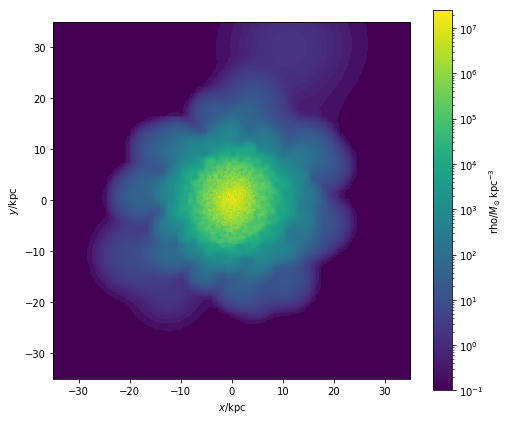

In [15]:
h5.physical_units()

pynbody.analysis.halo.center(h5)
pynbody.analysis.angmom.faceon(h5)
plt.figure(figsize=(8,7))
pynbody.plot.image(h5.s,width=70,vmin=1e-1)
plt.show()

# Satellite Luminosity Function for H1

Now lets do a satellite luminosity function for halo 1. We have already stored the indices of all of the satellites of H5 as the variable `children`. 

In [20]:
h1center = np.array([h[1].properties['Xc'],h[1].properties['Yc'],h[1].properties['Zc']])
print('Center coordinates of h1:',h1center)
h1rvir = h[1].properties['Rvir']
print('Virial radius of h1:',h1rvir)

def in_virial_radius(index):
    center = np.array([h[index].properties['Xc'],h[index].properties['Yc'],h[index].properties['Zc']])
    dif = center - h1center
    dist = np.sqrt(np.sum(np.square(dif)))
    if dist < h1rvir:
        return True
    else: 
        return False

Center coordinates of h1: [17121.67555528 16914.54322535 16660.74363926]
Virial radius of h1: 239.55


### Determine indices of satellite galaxies

Although the Amiga Halo Finder gives us a property field detailing the halo ID's that it considers 'children' of halo 1 (`h1`), this by default includes over 3000 satellites. We narrrow this down by ruling out all halos with `n_star = 0` and requiring that halos be within 1 virial radius of `h1`

In [21]:
children = np.array(h[1].properties['children'])
print('Initial AHF guess, # sats:',len(children))

children = [n for n in children if not h[n].properties['n_star']==0]
print('Number of satellites with stars:',len(children))

children = [n for n in children if in_virial_radius(n)]
print('Only within Rvir of h1:',len(children))

Initial AHF guess, # sats: 3197
Number of satellites with stars: 44
Only within Rvir of h1: 42


### Computing magnitudes of satellite galaxies

Now that we have a much smaller list (`N = 42`), we can loop through these halos and compute their V-band magnitudes using the `pynbody.analysis.luminosity.halo_mag` function. This is the most computationally intensive task here. 

In [83]:
mag = []
for i in children: 
    halo = h.load_copy(i) # load copy 
    with halo.immediate_mode: # futile attempt to speed up this process
        if not len(halo.star)==0:
            m = pynbody.analysis.luminosity.halo_mag(halo.s,band='v')
            print(str(i)+":",m)
            mag.append(m) # add back to magnitude list
    del halo # delete copy from memory (may be unnecessary)
    
mag = np.array(mag,dtype='float32')


2: -18.80710143056097
3: -17.750457080887955
5: -16.502942706027305
6: -16.397667550414585
9: -15.47227008334521
11: -16.08963622092927
12: -14.510813785878685
14: -13.2017312994598
26: -15.050303638022527
28: -14.621518017762412
31: -11.518856192470235
38: -5.868094564430115
42: -12.573772494848125
45: -8.50754261194237
46: -4.55140555562797
60: -5.32148163037008
64: -11.36807983000567
77: -13.277314640878808
80: -4.992603366214774
125: -9.947196162378116
131: -7.7201970824743515
223: -7.998226706526368
252: -9.291388472515498
264: -10.594661039645324
271: -10.767828619799452
304: -11.11802903555474
353: -5.025252482724499
372: -9.704043622819102
373: -6.347375993186512
435: -6.334987332881098
465: -7.985337209263213
590: -5.552673117993897
647: -5.2926957270783435
682: -11.475004356314756
869: -3.817185840318511
961: -5.697873101095588
1146: -3.7837713973921643
1155: -7.144315954270782
1381: -8.797196875145366
2792: -8.18218009061235
4897: -5.173904820867007
10814: -8.736175838607018

In [22]:
for i,m in zip(children,mag):
    print(h[i].properties['n_star'])


NameError: name 'mag' is not defined

### Make the Luminosity function plot

First we store a copy of this raw output and add in the Milky Way data. Note that the total h1 mass is $1.6\times 10^{12}~M_{\odot}$ and the total MW mass is approximately $6\times 10^{11}~M_{\odot}$, so our halo is about 2.5 times as massive as the MW. The milky way magnitudes below are taken directly from pg. 16 of <a href="https://iopscience.iop.org/article/10.1088/0004-6256/144/1/4/pdf">McConnachie (2012)</a>.

In [84]:
mag_raw = mag
MW = [-14.4,-13.5,-1.5,-4.2,-2.7,-2.5,-2.7,-4.1,-5.8,-18.1,-16.8,-6.3,-8.8,-8.8,-11.1,-9.3,-5.5,-9.1,-6.6,-13.4,-5.8,-4.9,-5.2,-5.0,-8.6,-9.8,-12] # McConnachie (2012)

Now we can plot the cumulative histogram of magnitude, for both the MW and simulation data. 

In [88]:
## get cumulative hist data points for simulation data

sim_y,sim_binEdges=np.histogram(mag)
sim_bincenters = 0.5*(sim_binEdges[1:]+sim_binEdges[:-1])
sim_y = np.flip(sim_y,axis=0)
for i in range(len(sim_y)):
    sim_y[i] = sum(sim_y[i:])
sim_y = np.flip(sim_y, axis=0)


## get cumulative hist data points for MW Data

mw_y,mw_binEdges=np.histogram(MW)
mw_bincenters = 0.5*(mw_binEdges[1:]+mw_binEdges[:-1])
mw_y = np.flip(mw_y,axis=0)
for i in range(len(mw_y)):
    mw_y[i] = sum(mw_y[i:])
mw_y = np.flip(mw_y, axis=0)

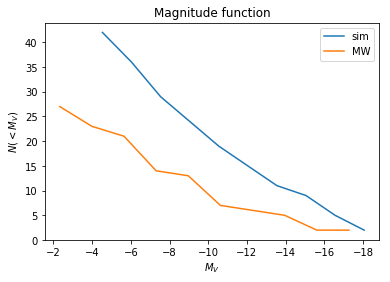

In [89]:
plt.figure()
plt.plot(sim_bincenters,sim_y,'-',label='sim')
plt.plot(mw_bincenters,mw_y,'-',label='MW')
plt.title('Magnitude function')
plt.ylabel(r'$N(<M_V)$')
plt.xlabel(r'$M_V$')
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('mag_function.png',dpi=300)
plt.show()

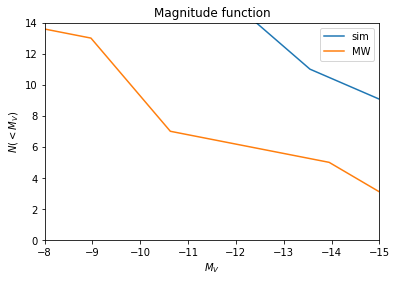

In [90]:
plt.figure()
plt.plot(sim_bincenters,sim_y,'-',label='sim')
plt.plot(mw_bincenters,mw_y,'-',label='MW')
plt.title('Magnitude function')
plt.ylabel(r'$N(<M_V)$')
plt.xlabel(r'$M_V$')
plt.legend()
### for comparison's sake: same limits as Fig 1 in Zolotov et al. 2012.
plt.xlim(-15,-8)
plt.ylim(0,14)
plt.gca().invert_xaxis()
plt.savefig('mag_function.png',dpi=300)
plt.show()